# **Fuzzy and Evolutionary Computing Project**

This project implements a complete **Particle Swarm Optimization** (PSO) **algorithm**—a population-based metaheuristic inspired by the collective behavior of bird flocks and fish schools—using the `softpy` framework.

Each potential solution (called a "*particle*") is represented by a **position** and a **velocity vector**
in a continuous search space.

During the optimization process, particles adjust their
positions based on their own experience, the experience of their neighbors, and the
experience of the global best performer, so to maximize a given **fitness function**.

The implementation includes:
- A **ParticleCandidate class**, inheriting from FloatVectorCandidate, defining the particle's
  position, velocity, and update rules (mutation and recombination).
- A **ParticleSwarmOptimizer class** that manages the population, neighbor selection, and
  the overall iterative optimization process.

The algorithm is evaluated on two benchmark functions: **`Sphere`** and **`Rastrigin`**.

## **Environment Setup and Imports**

To use the `softpy` library—which provides abstract classes and interfaces for implementing *metaheuristic* algorithms—we first clone its GitHub repository and install it locally in our environment.

In [ ]:
# Clone the official softpy repository
!git clone https://github.com/AndreaCampagner/softpy.git
%cd softpy
!pip install .
%cd ..

Cloning into 'softpy'...
remote: Enumerating objects: 696, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 696 (delta 90), reused 134 (delta 82), pack-reused 512 (from 1)
Receiving objects: 100% (696/696), 23.33 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (307/307), done.
/content/softpy
Processing /content/softpy
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 2.9 MB/s eta 0:00:00
  Created wheel for softpy: filename=softpy-0.1.2-py3-none-any.whl size=31284 sha256=9db1bd7cce6cb45b9ce5a72299b0992bf866e05b014c53e75d712da77f01d63e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rek5erbw/wheels/be/60/df/fc82f17d51b3407908360393a950f1f989601959b2136ee006
Successfully built softpy
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
ERROR: pip's dependency resolver does not 

In [ ]:
# Import Python and scientific computing libraries
import numpy as np
from scipy.stats import uniform
from copy import deepcopy
import matplotlib.pyplot as plt
import random

In [ ]:
# Import core classes from the softpy framework
from softpy.evolutionary.candidate import FloatVectorCandidate
from softpy.evolutionary.singlestate import MetaHeuristicsAlgorithm

## **1. ParticleCandidate Class**

This class extends `FloatVectorCandidate` and represents an individual particle in the swarm.

It introduces PSO-specific attributes, such as **velocity**, and uses **inertia** and **weighted influences** (local, neighborhood, global) to update its movement in the velocity formula.

It supports key methods needed by the softpy framework: `generate`, `mutate`, `recombine`, and `copy`.



In [ ]:
class ParticleCandidate(FloatVectorCandidate):
    def __init__(self, size: int, candidate: np.ndarray, velocity: np.ndarray,
                 distribution=uniform, lower=0.0, upper=1.0,
                 inertia=0.5, wl=0.3, wn=0.3, wg=0.4):

        # Initialize
        super().__init__(size=size, candidate=candidate,
                         distribution=distribution,
                         lower=lower, upper=upper,
                         mutate=None, recombine=None)

        # Ensure weights sum up to 1
        assert abs(wl + wn + wg - 1.0) < 1e-6, "Weights must sum to 1"

        self.velocity = velocity  # Current velocity of the particle
        self.inertia = inertia  # Inertia weight
        self.wl = wl  # Weight for local best influence
        self.wn = wn  # Weight for neighborhood best influence
        self.wg = wg  # Weight for global best influence

        # Ensure weights sum up to 1
        assert abs(wl + wn + wg - 1.0) < 1e-6, "Weights must sum to 1"

    @classmethod
    def generate(cls, size, lower, upper,
                 inertia=0.5, wl=0.3, wn=0.3, wg=0.4):

        # Generate a random candidate and initial velocity within bounds.
        lower = np.array(lower)
        upper = np.array(upper)

        # Generate initial position within bounds at random
        candidate = np.random.uniform(low=lower, high=upper)
        # Generate initial velocity within [-|range|, +|range|] at random
        vel_range = np.abs(upper - lower)
        velocity = np.random.uniform(low=-vel_range, high=vel_range)

        # Return a new ParticleCandidate
        return cls(size=size, candidate=candidate, velocity=velocity,
                   distribution=uniform, lower=lower, upper=upper,
                   inertia=inertia, wl=wl, wn=wn, wg=wg)

    def mutate(self):
        # Updates position by applying the current velocity
        new_candidate = self.candidate + self.velocity
        # Ensure new position stays within bounds
        new_candidate = np.clip(new_candidate, self.lower, self.upper)

        # Return new particle with updated position
        return ParticleCandidate(
            size=self.size,
            candidate=new_candidate,
            velocity=self.velocity,   # Velocity does not change
            distribution=self.distribution,
            lower=self.lower,
            upper=self.upper,
            inertia=self.inertia,
            wl=self.wl,
            wn=self.wn,
            wg=self.wg
        )

    def recombine(self, local_best, neighborhood_best, global_best):
        # Updates the velocity based on the local, neighborhood, and global bests.
        rl = np.random.uniform(size=self.size)
        rn = np.random.uniform(size=self.size)
        rg = np.random.uniform(size=self.size)

        # Update velocity using the PSO formula
        new_velocity = (
            self.inertia * self.velocity
            + self.wl * rl * (local_best.candidate - self.candidate)
            + self.wn * rn * (neighborhood_best.candidate - self.candidate)
            + self.wg * rg * (global_best.candidate - self.candidate)
        )

        # Return new particle with updated velocity
        return ParticleCandidate(
            size=self.size,
            candidate=self.candidate,
            velocity=new_velocity,
            distribution=self.distribution,
            lower=self.lower,
            upper=self.upper,
            inertia=self.inertia,
            wl=self.wl,
            wn=self.wn,
            wg=self.wg
        )

    def copy(self):
        # Returns a deep copy of the current particle
        return ParticleCandidate(
            size=self.size,
            candidate=np.copy(self.candidate),
            velocity=np.copy(self.velocity),
            distribution=self.distribution,
            lower=np.copy(self.lower),
            upper=np.copy(self.upper),
            inertia=self.inertia,
            wl=self.wl,
            wn=self.wn,
            wg=self.wg
        )

## **2. ParticleSwarmOptimizer Class**

This class implements the main **PSO algorithm**.

It maintains a swarm of particles, tracks personal and global bests, and updates each particle by combining influences from:

*   Its own **personal best**,
*   The **best among** randomly **selected** neighbors,
*   The **global best** particle in the population.

The optimization proceeds iteratively, and the best fitness value is tracked at each step.

In [ ]:
class ParticleSwarmOptimizer(MetaHeuristicsAlgorithm):
    def __init__(self, candidate_type, fitness_func, pop_size, n_neighbors, **kwargs):
        # Initialize the base MetaHeuristicsAlgorithm
        super().__init__(candidate_type=candidate_type, fitness_func=fitness_func)

        assert n_neighbors < pop_size, "n_neighbors must be less than pop_size"
        assert 'dim' in kwargs and 'lower_bound' in kwargs and 'upper_bound' in kwargs

        # PSO-specific parameters
        self.candidate_type = candidate_type
        self.fitness_func = fitness_func   # Objective function to evaluate each particle
        self.pop_size = pop_size  # Total number of particles in the swarm
        self.n_neighbors = n_neighbors  # Number of neighbors considered for each particle
        self.kwargs = kwargs  # Extra parameters

        self.population = []  # List of ParticleCandidate instances

        # Local best positions and their fitness values for each particle
        self.best = [None] * pop_size
        self.fitness_best = np.full(pop_size, -np.inf)

        # Global best position and its fitness value among all particles
        self.global_best = None
        self.global_fitness_best = -np.inf

        self.fitness_progress = []  # List to track the best fitness score at each iteration

    def fit(self, n_iters=100):
        # Initializes the swarm and performs the iterative optimization process
        dim = self.kwargs["dim"]
        lower = [self.kwargs["lower_bound"]] * dim
        upper = [self.kwargs["upper_bound"]] * dim

        self.population = [
            self.candidate_type.generate(
                size=dim,
                lower=lower,
                upper=upper
            ) for _ in range(self.pop_size)
        ]

        for it in range(n_iters):
            # Fitness evaluation and personal/global best updates
            for i, particle in enumerate(self.population):
                fitness = self.fitness_func(particle)

                # Update personal best
                if fitness > self.fitness_best[i]:
                    self.fitness_best[i] = fitness
                    self.best[i] = particle.copy()

                # Update global best
                if fitness > self.global_fitness_best:
                    self.global_fitness_best = fitness
                    self.global_best = particle.copy()

            # Save current global best fitness for plotting or analysis
            self.fitness_progress.append(self.global_fitness_best)

            # Neighborhood-based recombination and mutation
            for i in range(self.pop_size):
                # Select random neighbors (excluding self)
                neighbors = random.sample([j for j in range(self.pop_size) if j != i], self.n_neighbors)

                # Identify the best neighbor among the selected ones
                best_neighbor_idx = max(neighbors, key=lambda j: self.fitness_best[j])
                best_neighbor = self.best[best_neighbor_idx]

                # Recombine to update velocity
                new_particle = self.population[i].recombine(
                    local_best=self.best[i],
                    neighborhood_best=best_neighbor,
                    global_best=self.global_best
                ).mutate()

                # Apply mutation to update position
                self.population[i] = new_particle

            # Print current iteration and global best fitness value
            print(f"Iteration {it+1}/{n_iters} - Global Best Fitness: {self.global_fitness_best:.6f}")

        self.best = self.global_best
        self.fitness_best = self.global_fitness_best
        self.is_fitted = True
        return self.best

## **3. Testing the PSO with Benchmark Functions**

To evaluate the **effectiveness** of the PSO algorithm, we apply it to two standard continuous benchmark functions:

*  The **Sphere function** (convex, unimodal)
*  The **Rastrigin function** (non-convex, multimodal)

### **Sphere Function Method**

In [ ]:
# Sphere Function - Maximization of the negative of sum of squares
def sphere_function(candidate: ParticleCandidate) -> float:
    return -np.sum(candidate.candidate ** 2)

In [ ]:
# PSO Setup and Execution
pso = ParticleSwarmOptimizer(
    candidate_type=ParticleCandidate,   # Particle type
    fitness_func=sphere_function,   # Objective function
    pop_size=30,  # Number of particles in the swarm
    n_neighbors=5,  # Number of neighbors for recombination
    dim=5,  # Size of the problem
    lower_bound=-10,  # Lower bound of search space
    upper_bound=10  # Upper bound of search space
)

# Run the optimization for a fixed number of iterations
best = pso.fit(n_iters=50)

# Output the best result found
print("Best fitness found:", pso.global_fitness_best)
print("Best position found:")
print(pso.global_best.candidate)

Iteration 1/50 - Global Best Fitness: -48.889508
Iteration 2/50 - Global Best Fitness: -48.889508
Iteration 3/50 - Global Best Fitness: -48.889508
Iteration 4/50 - Global Best Fitness: -21.030046
Iteration 5/50 - Global Best Fitness: -7.924185
Iteration 6/50 - Global Best Fitness: -4.396664
Iteration 7/50 - Global Best Fitness: -1.418098
Iteration 8/50 - Global Best Fitness: -1.398543
Iteration 9/50 - Global Best Fitness: -0.613931
Iteration 10/50 - Global Best Fitness: -0.174382
Iteration 11/50 - Global Best Fitness: -0.081675
Iteration 12/50 - Global Best Fitness: -0.080820
Iteration 13/50 - Global Best Fitness: -0.020506
Iteration 14/50 - Global Best Fitness: -0.014874
Iteration 15/50 - Global Best Fitness: -0.005745
Iteration 16/50 - Global Best Fitness: -0.005133
Iteration 17/50 - Global Best Fitness: -0.004943
Iteration 18/50 - Global Best Fitness: -0.001928
Iteration 19/50 - Global Best Fitness: -0.000585
Iteration 20/50 - Global Best Fitness: -0.000359
Iteration 21/50 - Global 

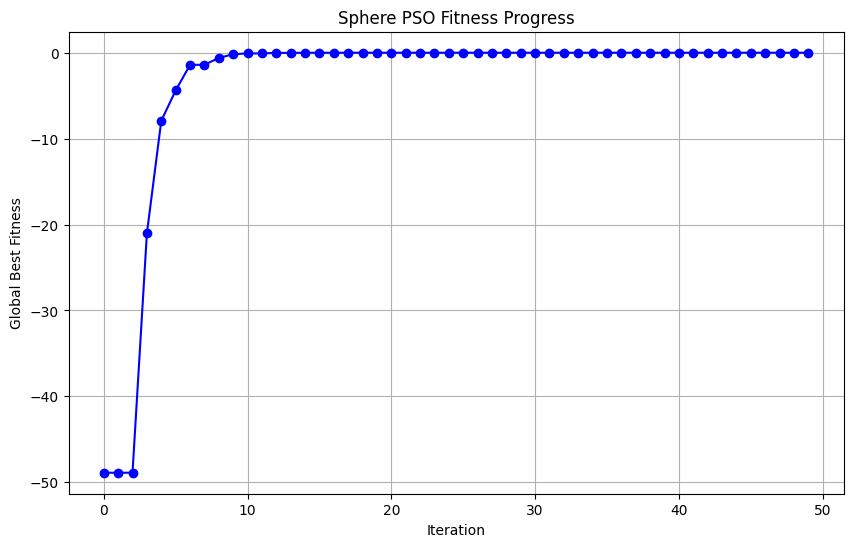

In [ ]:
# Plotting the fitness progress
plt.figure(figsize=(10, 6))
plt.plot(pso.fitness_progress, marker='o', linestyle='-', color='b')
plt.title('Sphere PSO Fitness Progress')
plt.xlabel('Iteration')
plt.ylabel('Global Best Fitness')
plt.grid(True)
plt.show()

### **Rastrigin Function Method**

In [ ]:
# Rastrigin Function - Non-convex multimodal test function
def rastrigin_function(candidate):
    A = 10
    x = candidate.candidate
    return -(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

In [ ]:
# PSO Setup and Execution
pso = ParticleSwarmOptimizer(
    candidate_type=ParticleCandidate,
    fitness_func=rastrigin_function,
    pop_size=30,
    n_neighbors=5,
    dim=5,
    lower_bound=-5.12,
    upper_bound=5.12
)

# Run the optimization for a fixed number of iterations
best = pso.fit(n_iters=50)

# Output the best result found
print("Best fitness found:", pso.global_fitness_best)
print("Best position found:")
print(pso.global_best.candidate)

Iteration 1/50 - Global Best Fitness: -54.518210
Iteration 2/50 - Global Best Fitness: -46.320994
Iteration 3/50 - Global Best Fitness: -46.320994
Iteration 4/50 - Global Best Fitness: -46.320994
Iteration 5/50 - Global Best Fitness: -37.194644
Iteration 6/50 - Global Best Fitness: -26.487504
Iteration 7/50 - Global Best Fitness: -26.487504
Iteration 8/50 - Global Best Fitness: -26.487504
Iteration 9/50 - Global Best Fitness: -26.487504
Iteration 10/50 - Global Best Fitness: -26.487504
Iteration 11/50 - Global Best Fitness: -9.370174
Iteration 12/50 - Global Best Fitness: -9.370174
Iteration 13/50 - Global Best Fitness: -9.370174
Iteration 14/50 - Global Best Fitness: -9.370174
Iteration 15/50 - Global Best Fitness: -9.370174
Iteration 16/50 - Global Best Fitness: -7.944853
Iteration 17/50 - Global Best Fitness: -7.483331
Iteration 18/50 - Global Best Fitness: -7.483331
Iteration 19/50 - Global Best Fitness: -7.285601
Iteration 20/50 - Global Best Fitness: -7.173769
Iteration 21/50 - G

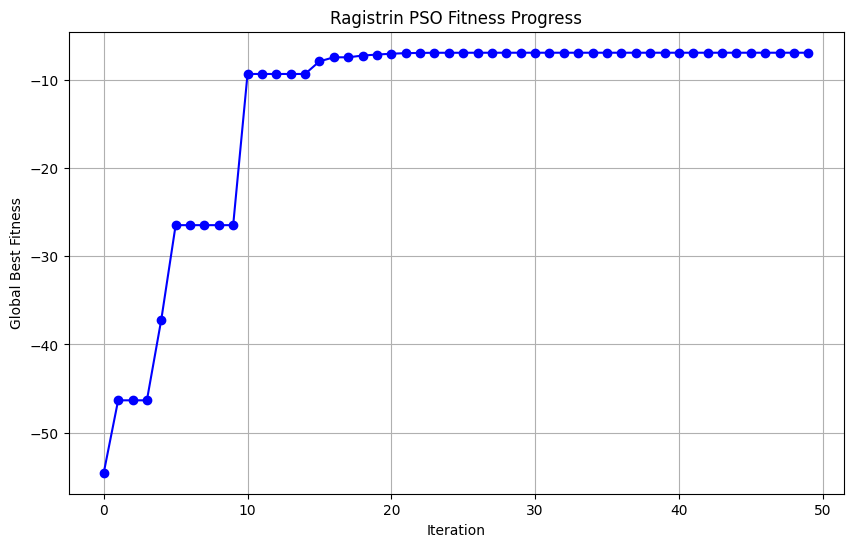

In [ ]:
# Plotting the fitness progress
plt.figure(figsize=(10, 6))
plt.plot(pso.fitness_progress, marker='o', linestyle='-', color='b')
plt.title('Ragistrin PSO Fitness Progress')
plt.xlabel('Iteration')
plt.ylabel('Global Best Fitness')
plt.grid(True)
plt.show()